# Test some effects of the fringe rate filter

I will use a "simulated" main lobe filter that selects a range of Fourier modes out of a signal that represents the noise in one baseline, one frequency over time. However, the selection is not random, it uses a length of time that is real, fringe-rates that are calculated from that length of time, and a set of fringe-rates that are realistic for a main-lobe filter assuming a certain baseline in HERA. The actual values are loaded from files supplied by Aaaron Ewall-Wice and are used for the simulated pipeline that simulates noise in real observations.

In [71]:
import numpy as np
import scipy.stats
from astropy import units
import uvtools
from hera_pspec.conversions import Cosmo_Conversions
import pickle
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import time

plt.rcParams['figure.figsize'] = [14, 10]
plt.rcParams["font.size"] = "14"


# WINDOW function on FFT?

# Setup parameters
np.random.seed(5432)

SPECTRAL_WINDOW = 0

# ------------------------------
# Depend on spectral window
FRATE_FILTERS_FILE = "fr_ranges_"+str(SPECTRAL_WINDOW)+".pkl"

KBINS_FILE = "pre_release_maxbl_100m_minew_14m_kbins_SPW_"+str(SPECTRAL_WINDOW)+".pkl"
with open(KBINS_FILE, 'rb') as pickle_file:
    bins = pickle.load(pickle_file)



# These can be anything

LSTS_PER_NIGHT = 2160           # number them 0, 1, 2, etc


START_TIME = 2458902.4


# Based on above
FAKE_TIMES = np.array([ START_TIME+i*INTEGRATION_TIME/SECONDS_IN_DAY for i in range(LSTS_PER_NIGHT) ])



In [72]:
def fringe_rates(times):
    fr = uvtools.utils.fourier_freqs(times * units.day.to("s"))
    fr *= units.Hz.to("mHz")
    
    return fr    

def plot_histogram(a, xlabel, nbins=128, vals=False):

    def r(x):
        return np.round(x, 2)     # set_precision is not working for some reason at this time in the universe

    if a.dtype == np.complex128:
        real_hist, real_edges = np.histogram(a.real, bins=nbins)
        imag_hist, imag_edges = np.histogram(a.imag, bins=nbins)
        amp_hist, amp_edges = np.histogram(np.abs(a), bins=nbins)
        real_bins = (real_edges[:-1]+real_edges[1:])/2
        imag_bins = (imag_edges[:-1]+imag_edges[1:])/2
        amp_bins = (amp_edges[:-1]+amp_edges[1:])/2
        
        if vals:
            return real_hist, real_bins, imag_hist, imag_bins, amp_hist, amp_bins
        
        print("Real. Mean:", r(np.mean(a.real)), "Std", np.std(a.real), "Skew", r(scipy.stats.skew(a.real)), 
              "Kurtosis", r(scipy.stats.kurtosis(a.real)))
        print("Imag. Mean:", r(np.mean(a.imag)), "Std", np.std(a.imag), "Skew", r(scipy.stats.skew(a.imag)), 
              "Kurtosis", r(scipy.stats.kurtosis(a.imag)))
        print("Amp. Mean:", r(np.mean(np.abs(a))), "Std", np.std(np.abs(a)), "Skew", r(scipy.stats.skew(np.abs(a))), 
              "Kurtosis", r(scipy.stats.kurtosis(a.imag)))
        
        plt.title("Histogram")
        plt.ylabel("Count")
        plt.xlabel(xlabel)
        plt.plot(real_bins, real_hist, label="Real")
        plt.plot(imag_bins, imag_hist, label="Imag")
        plt.plot(amp_bins, amp_hist, label="Amp")
        plt.legend()
    else:
        hist, edges = np.histogram(a.real, bins=nbins)
        bins = (edges[:-1]+edges[1:])/2
        
        if vals:
            return hist, bins
        
        print("Mean:", np.mean(a.real), "Skew:", scipy.stats.skew(a.real), "Kurtosis:", scipy.stats.kurtosis(a.real))
 
        plt.title("Histogram")
        plt.ylabel("Count")
        plt.xlabel("Covariance")
        plt.plot(bins, hist)



    
def fringe_rate_filter(bl_by_time, bls_to_use):
    """
    Expecting a list of observations in time. Each observation is a dictionary of different baselines.
    A baseline is a 1-D array of length nfreqs.
    """
    
    
    f = FRATE_FILTERS_FILE
    with open(f, 'rb') as pickle_file:
        rates = pickle.load(pickle_file)

    
    if len(bl_by_time) == len(FAKE_TIMES):
        frates = fringe_rates(FAKE_TIMES)
    else:
        print("Calculating fringe rates for integrated times")
        assert FAKE_TIMES.size%len(bl_by_time) == 0, "Can't reduce times for FRF"
        scrunch_factor = len(FAKE_TIMES)//len(bl_by_time)
        frf_fake_times = np.mean(np.resize(FAKE_TIMES, (FAKE_TIMES.size//scrunch_factor, scrunch_factor)), axis=1)
        frates = fringe_rates(frf_fake_times)
        
    # Get nfreqs
    key0 = list(bl_by_time[0].keys())[0]
    nfreq = bl_by_time[0][key0].size
           
    start = time.time()
    for bl in bls_to_use:
        
        # See if all times are None or all not None
        all_None = len([ bls[bl] for bls in bl_by_time if bls[bl] is None ]) == len(bl_by_time)
        all_not_None = len([ bls[bl] for bls in bl_by_time if bls[bl] is not None ]) == len(bl_by_time)
        
        assert (all_None and not all_not_None) or (not all_None and all_not_None), "BL "+str(bl)+"has some None baselines"

        if all_not_None:
            # Form an array that is the baseline by time. What about if baseline is missing in one time.
            data = np.zeros((len(bl_by_time), nfreq), complex)


            for i in range(len(bl_by_time)):
                data[i] = bl_by_time[i][bl] 

            fft = np.fft.fftshift(np.fft.fft(data, axis=0), axes=0)
            # now for a frequency index F, fft[:, F] is the fft by time with the -ve frequencies, then DC
            # then the +ve frequencies. If there are 8 times then the modes are  -4 -3 -2 -1 0 1 2 3

            # Find the tophat filter vals for this baseline
            key = (bl[0], bl[1], "ee")
            centre = rates[0][key]
            width = rates[1][key]
            #print(centre, width)

            # left and right edges of the tophat. These are fringe rates.
            left = centre-width/2
            right = centre+width/2

            # Find the index of these fringe rates. The bottom then the top
            indexes = np.arange(frates.size, dtype=int)
            left_index = np.where(frates<left)[0][-1]-1
            right_index = np.where(frates>right)[0][0]+1
            assert left_index < right_index, "fringe rates don't have enough resolution"

            #print(left_index, right_index)
            #print(frates[left_index], frates[right_index]); 
            # Now zero everything outside of the tophat
            fft[:left_index, :] = 0j
            fft[right_index:, :] = 0j

            # Now put things back. Invert the fft.
            data = np.fft.ifft(np.fft.ifftshift(fft, axes=0), axis=0)

            for i in range(len(bl_by_time)):
                bl_by_time[i][bl] = data[i]
            
    #print("FRF time", time.time()-start)   

    



# Test fringe-rate filter


In [73]:
BL = (178, 130)
BL = (24, 124)


# The noise data for the baseline over time and freq

one_bl_data_over_time = np.random.normal(size=len(FAKE_TIMES))+np.random.normal(size=len(FAKE_TIMES))*1j

f = FRATE_FILTERS_FILE
with open(f, 'rb') as pickle_file:
    rates = pickle.load(pickle_file) 
    
fr_centre = rates[0][(BL[0], BL[1], "ee")]
fr_width = rates[1][(BL[0], BL[1], "ee")]

# Calculate where the fringe rate centre and boundaries lie

frates = fringe_rates(FAKE_TIMES)

fr_centre_i = np.where(frates>=fr_centre)[0][0]
# Make these match what the code above does
fr_left_i = np.where(frates<fr_centre-fr_width/2)[0][-1]
fr_right_i = np.where(frates>fr_centre+fr_width/2)[0][0]

print(fr_left_i, fr_centre_i, fr_right_i)

1063 1067 1069


## Before FRF

Pick a frequency and plot the FFT, and data over time


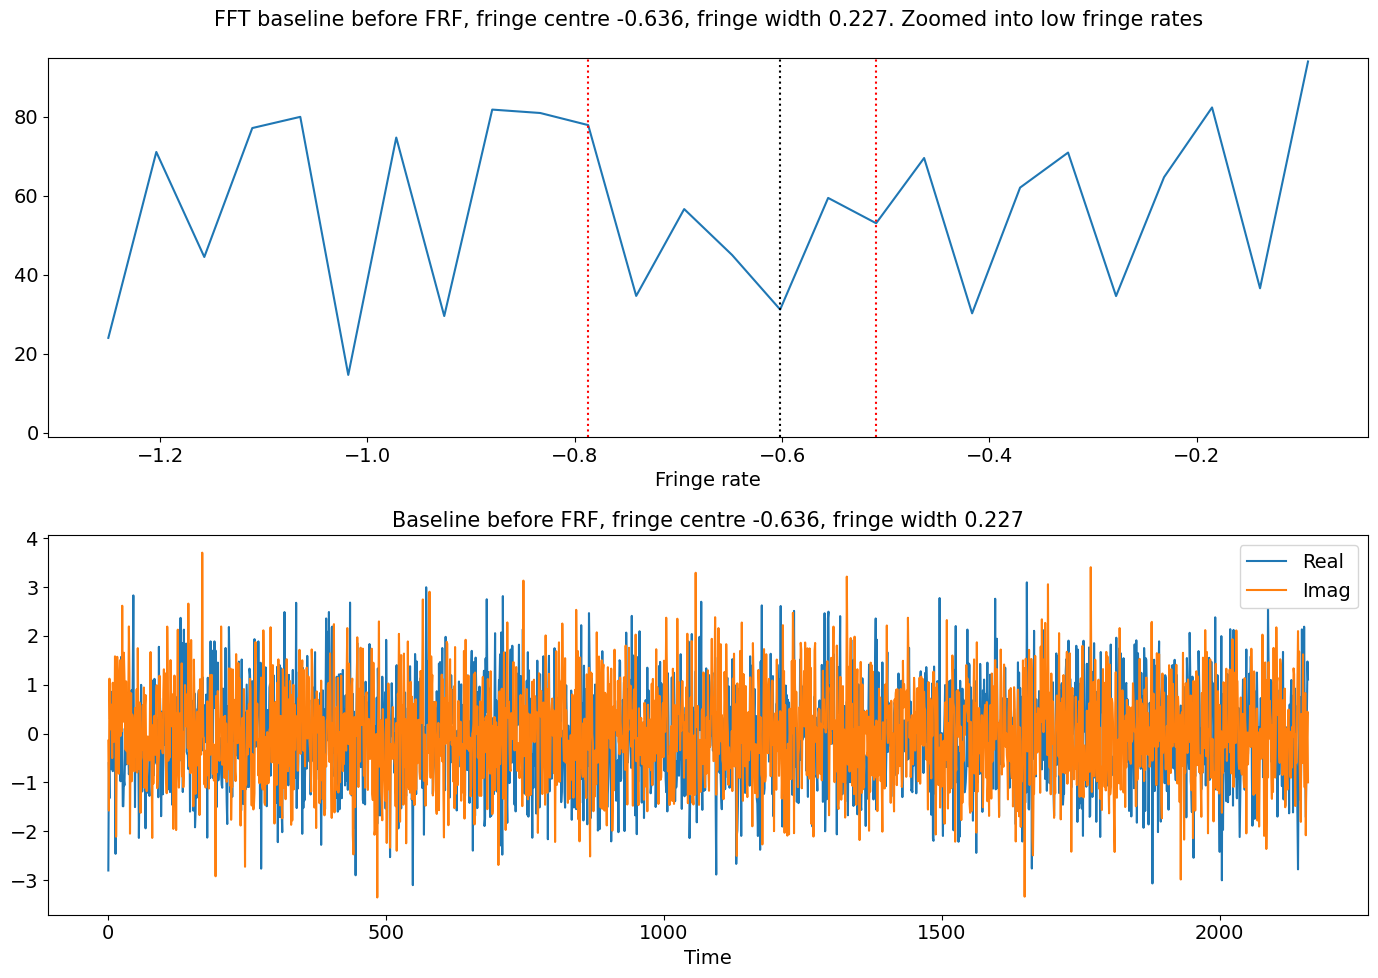

In [74]:
fft = np.abs(np.fft.fftshift(np.fft.fft(one_bl_data_over_time)))
max_fft = np.max(fft[fr_left_i-10:fr_right_i+10])
plt.subplot(2, 1, 1)
plt.plot(frates[fr_left_i-10:fr_right_i+10], fft[fr_left_i-10:fr_right_i+10])
plt.xlabel("Fringe rate")
plt.axvline(frates[fr_left_i], color="red", linestyle=":")
plt.axvline(frates[fr_right_i], color="red", linestyle=":")
plt.axvline(frates[fr_centre_i], color="black", linestyle=":")
plt.ylim(-1, max_fft+1)
plt.title("FFT baseline before FRF, fringe centre "+str(round(fr_centre, 3))+", fringe width "+str(round(fr_width, 3))+". Zoomed into low fringe rates\n",
             fontsize="15")
plt.subplot(2, 1, 2)
plt.plot(np.real(one_bl_data_over_time), label="Real")
plt.plot(np.imag(one_bl_data_over_time), label="Imag")
plt.xlabel("Time")
plt.legend()
plt.title("Baseline before FRF, fringe centre "+str(round(fr_centre, 3))+", fringe width "+str(round(fr_width, 3)),
             fontsize="15")
plt.tight_layout()

Real. Mean: -0.01 Std 0.9881068415199502 Skew 0.02 Kurtosis -0.04
Imag. Mean: -0.01 Std 0.9806016527169643 Skew 0.12 Kurtosis 0.06
Amp. Mean: 1.24 Std 0.6408349462036266 Skew 0.65 Kurtosis 0.06


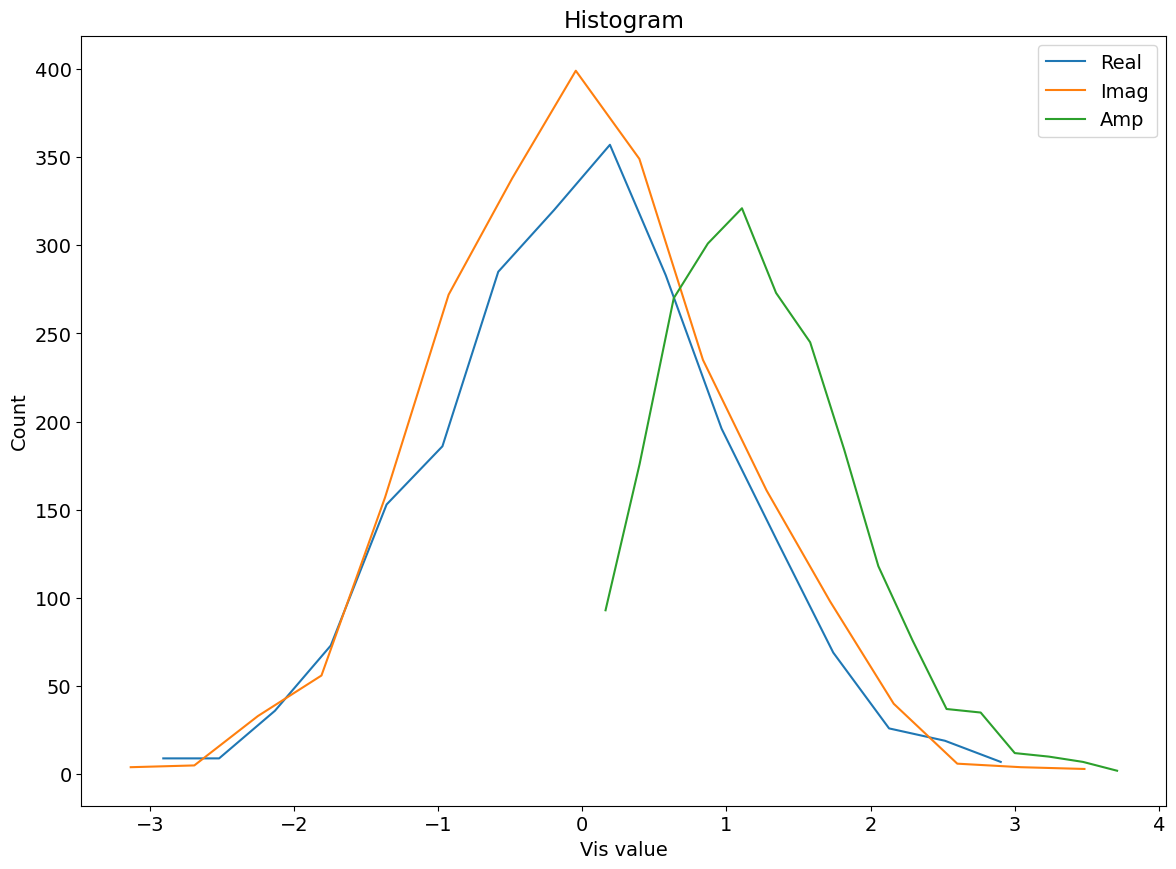

In [75]:
plot_histogram(one_bl_data_over_time, xlabel="Vis value", nbins=16)

### The covariance matrix of noise over time

Gaussian noise - the covariance matrix should be diagonal.

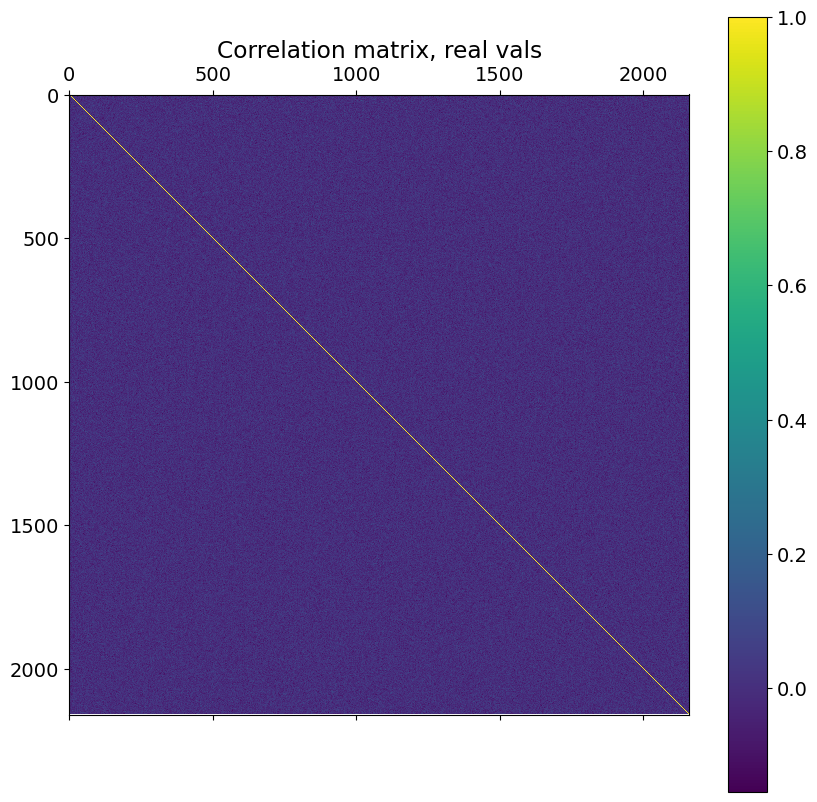

In [76]:
NTRIAL = 1000

trials = np.empty((NTRIAL, len(FAKE_TIMES)), dtype=np.complex128)

for i in range(NTRIAL):
    data = np.random.normal(size=len(FAKE_TIMES))+np.random.normal(size=len(FAKE_TIMES))*1j

    trials[i] = data

sigmas = np.std(trials.real), np.std(trials.imag)
plot_corrcoef(trials.real.T, "Correlation matrix, real vals")


### Test coherent integration of noise

Integrate times by a factor of 10.

Factor sigma reduction due to coherent integration 3.1574728723654086 3.165457838930544

Plot a histogram of 1 coherently integrated down tiime length
Real. Mean: -0.01 Std 0.34271744516025443 Skew 0.18 Kurtosis -0.04
Imag. Mean: -0.0 Std 0.3167781506024014 Skew 0.0 Kurtosis -0.21
Amp. Mean: 0.43 Std 0.19123659489099534 Skew 0.82 Kurtosis -0.21


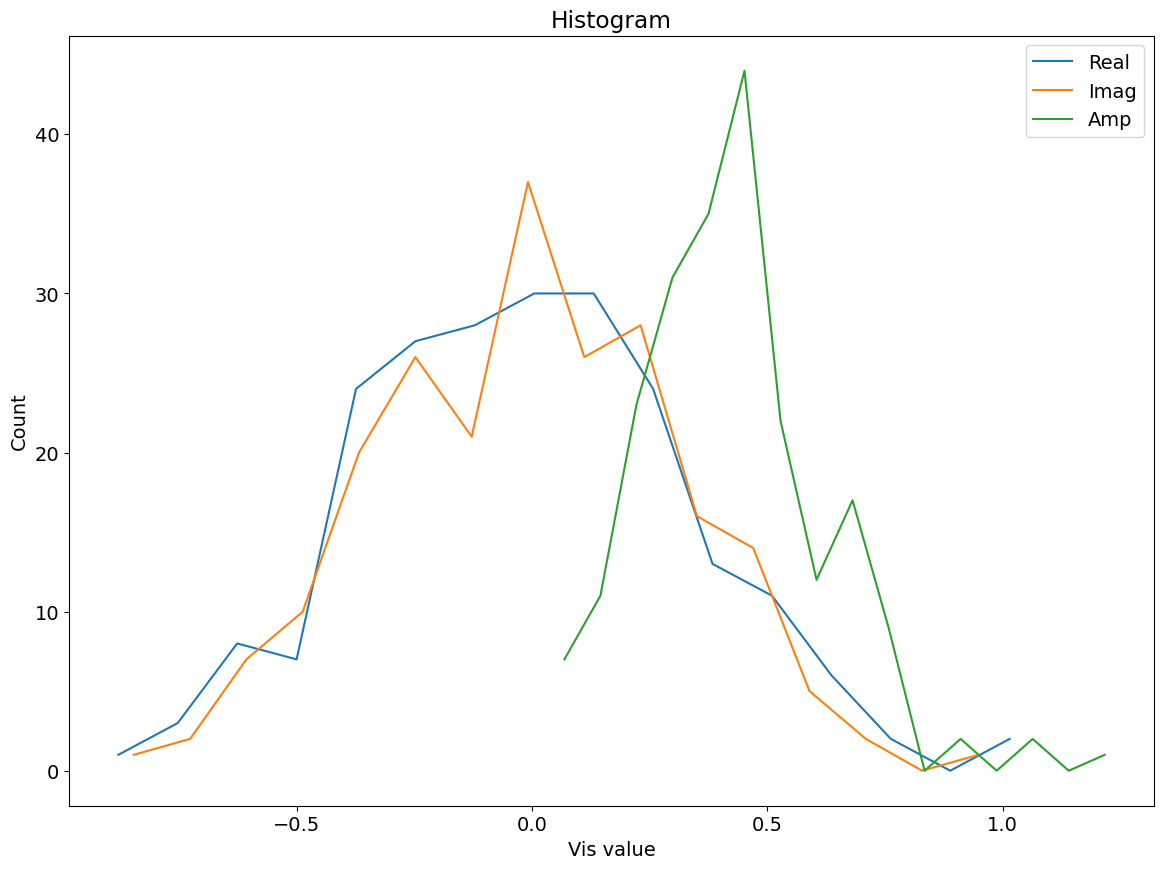

In [77]:
trials = np.reshape(trials, (NTRIAL, FAKE_TIMES.size//10, 10))
trials = np.mean(trials, axis=2)

print("Factor sigma reduction due to coherent integration", sigmas[0]/np.std(trials.real), sigmas[1]/np.std(trials.imag))
print()
print("Plot a histogram of 1 coherently integrated down tiime length")

plot_histogram(trials[0], nbins=16, xlabel="Vis value")

The separate arrays have a sigma of 1 in the real/imag components but this is reduced to 0.3. The factor reduction in sigma is.

### After FRF

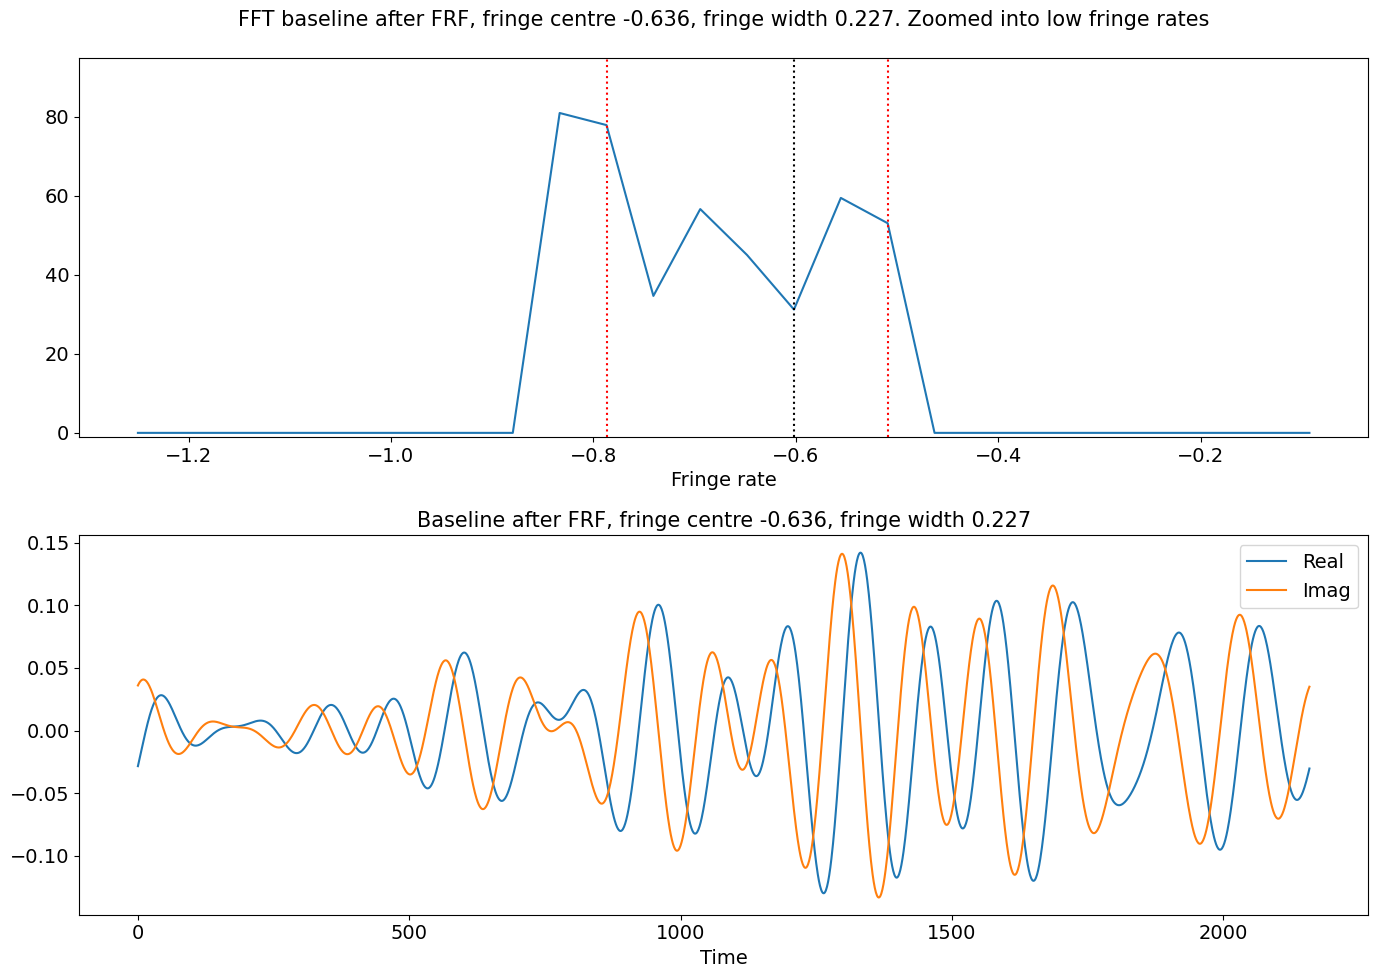

In [78]:
bl_over_time = []
for i in range(len(FAKE_TIMES)):
    bl_over_time.append({ BL : one_bl_data_over_time[i] })
fringe_rate_filter(bl_over_time, [BL])
bl_one_freq = [ bl[BL][0] for bl in bl_over_time ]
plt.subplot(2, 1, 1)
plt.plot(frates[fr_left_i-10:fr_right_i+10], np.abs(np.fft.fftshift(np.fft.fft(bl_one_freq)))[fr_left_i-10:fr_right_i+10])
plt.axvline(frates[fr_left_i], color="red", linestyle=":")
plt.axvline(frates[fr_right_i], color="red", linestyle=":")
plt.axvline(frates[fr_centre_i], color="black", linestyle=":")
plt.ylim(-1, max_fft+1)
plt.xlabel("Fringe rate")
plt.title("FFT baseline after FRF, fringe centre "+str(round(fr_centre, 3))+", fringe width "+str(round(fr_width, 3))+". Zoomed into low fringe rates\n",
             fontsize="15")
plt.subplot(2, 1, 2)
plt.plot(np.real(bl_one_freq), label="Real")
plt.plot(np.imag(bl_one_freq), label="Imag")
plt.xlabel("Time")
plt.legend()
plt.title("Baseline after FRF, fringe centre "+str(round(fr_centre, 3))+", fringe width "+str(round(fr_width, 3)), fontsize="15")
plt.tight_layout()

Real. Mean: -0.0 Std 0.05314910489304065 Skew 0.0 Kurtosis -0.19
Imag. Mean: -0.0 Std 0.05314910489304066 Skew 0.0 Kurtosis -0.19
Amp. Mean: 0.07 Std 0.03763097135777077 Skew 0.14 Kurtosis -0.19


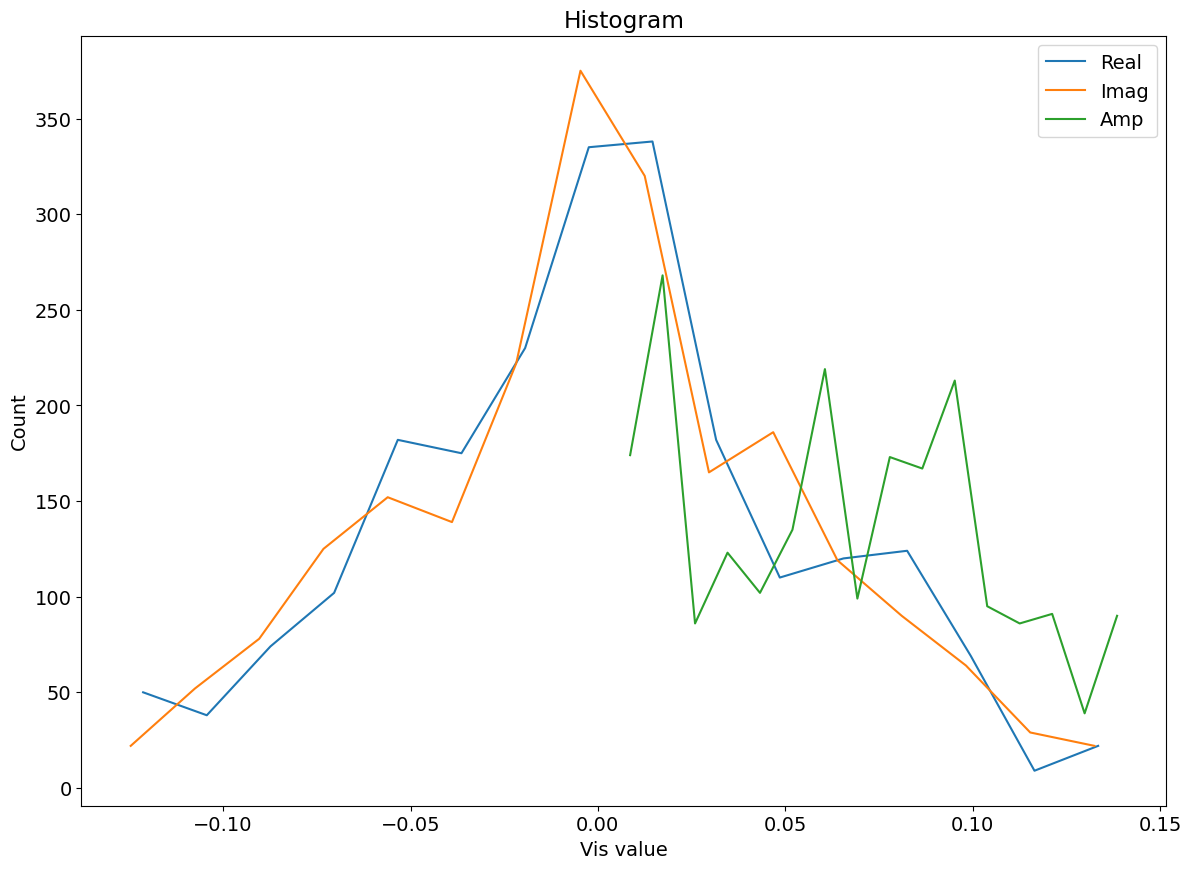

In [79]:
plot_histogram(np.array(bl_one_freq), xlabel="Vis value", nbins=16)

### What happens to the covariance matrix of a noise baseline after fringe-rate filtering

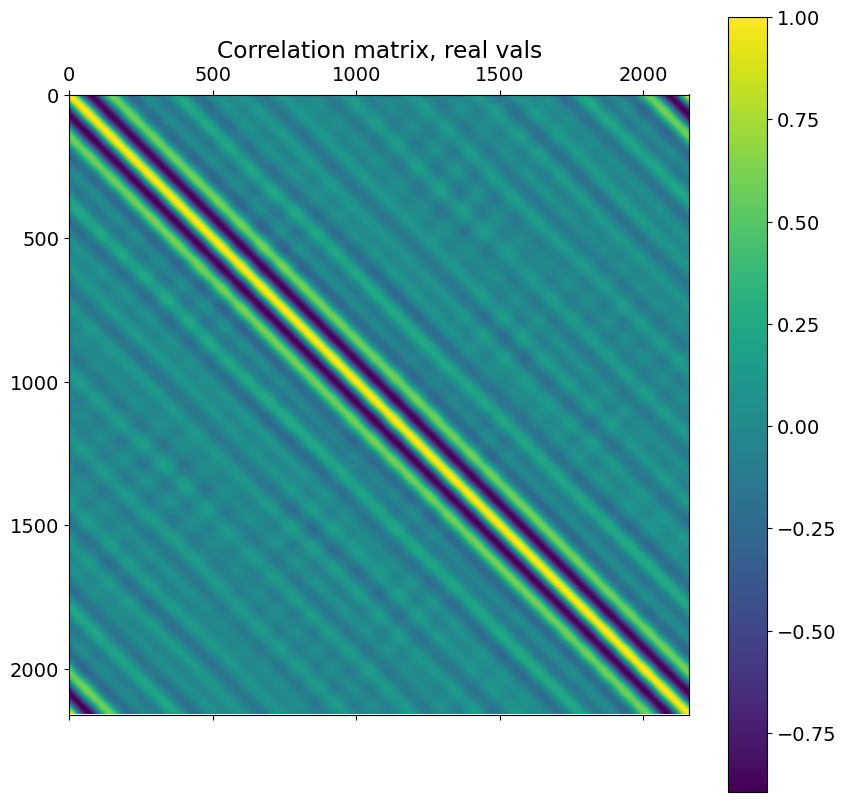

In [80]:
NTRIAL = 1000

trials = np.empty((NTRIAL, len(FAKE_TIMES)), dtype=np.complex128)

for i in range(NTRIAL):
    one_bl_data_over_time = np.random.normal(size=len(FAKE_TIMES))+np.random.normal(size=len(FAKE_TIMES))*1j

    bl_over_time = []
    for j in range(len(FAKE_TIMES)):
        assert one_bl_data_over_time[j] != 0j
        bl_over_time.append({ BL : one_bl_data_over_time[j] })
    fringe_rate_filter(bl_over_time, [BL])
    trials[i] = np.array([ bl[BL][0] for bl in bl_over_time ])


sigmas = (np.std(trials.real), np.std(trials.imag))
plot_corrcoef(trials.real.T, "Correlation matrix, real vals")

### Test coherent integration

Reduce the times by integrating down by a factor of 10. 

Factor sigma reduction due to coherent integration 1.0075308101446727 1.0075308101446727

Plot a histogram of 1 coherently integrated down tiime length
Real. Mean: 0.0 Std 0.04651076713361275 Skew -0.0 Kurtosis -0.63
Imag. Mean: 0.0 Std 0.04651076713361275 Skew -0.0 Kurtosis -0.63
Amp. Mean: 0.06 Std 0.02574127414401537 Skew 0.13 Kurtosis -0.63


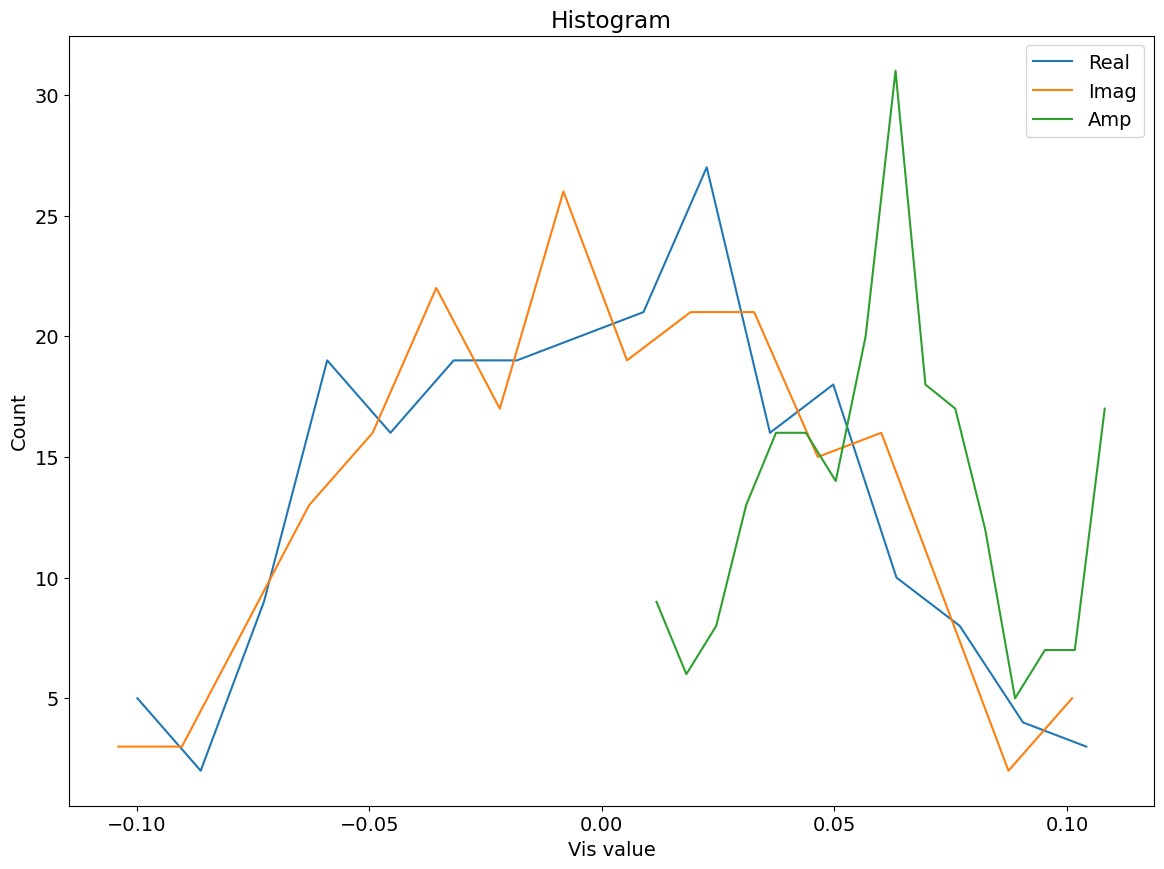

In [81]:
trials = np.reshape(trials, (NTRIAL, FAKE_TIMES.size//10, 10))
trials = np.mean(trials, axis=2)

print("Factor sigma reduction due to coherent integration", sigmas[0]/np.std(trials.real), sigmas[1]/np.std(trials.imag))
print()
print("Plot a histogram of 1 coherently integrated down tiime length")

plot_histogram(trials[0], nbins=16, xlabel="Vis value")

The factor sigma reduction is 1. Not good. Also the histogram is not Gaussian.